# Seminarni prace - Eva Matouskova

### Zadani:

1) Stáhněte si nějaké aktivní struktury pro jeden cíl (nejlépe z ChEMBLu), bylo by dobré, kdyby byly už s naměřenou hodnotou např. EC50, IC50
    - Lépe rovnou agonisty a antagonisty
    - Je potřeba alespoň 200 látek

2) Vytvořte s Vašimi aktivními látkami PCA mapu, buď vyneste a porovnejte ago a anta, nebo použijte náhodné sloučeniny jako pozadí.

3) Natrénujte model, který predikuje aktivitu. Popř. klasifikátor, který určí, zda se jedná o antagonistu nebo agonistu.
    - Použijte rozumné deskriptory a predikční výkon určtete nějakou vhodnou metrikou.
    
### Vybrane latky:
- target ID: CHEMBL233
    - mu opioid receptor
- 1020 latek
    - EC50: 586
    - IC50: 434


In [1]:
from rdkit.Chem import AllChem as Chem

# nacteni csv
import pandas as pd

#aby to vykreslovalo molekuly
from rdkit.Chem.Draw import IPythonConsole 

#knihovny pro vypocet descriptoru (potrebujeme cislo)
from rdkit.Chem import Lipinski
from rdkit.Chem import rdMolDescriptors
from rdkit.Chem import Descriptors

#kresleni grafu
import seaborn
import matplotlib

#pro PCA
from sklearn import decomposition
from sklearn import preprocessing

#picking
#from sklearn.metrics.pairwise import euclidean_distances
from rdkit.SimDivFilters.rdSimDivPickers import MaxMinPicker
from math import sqrt

#deleni dat do mnozin + cross validace
from sklearn import model_selection

#regese
from sklearn.ensemble import RandomForestRegressor

#graf
import seaborn as sns

#mira korelace
from sklearn.metrics import r2_score, mean_squared_error
import math

#MQN
from rdkit.Chem import rdMolDescriptors

## 1. Nacteni latek

In [2]:
#nacteni ligandu
#ligands = pd.read_csv('mu_ligands.csv', error_bad_lines=False)
ligands = pd.read_csv('ligands.csv',sep=';',encoding = "ISO-8859-1")

len(ligands)

1020

In [3]:
ligands[:5]

,Molecule,Standard Type,Standard Relation,Standard Value,Standard Units,pChEMBL Value,Comment,Compound Key,Assay,Assay Description,...,Published Relation,Published Value,Published Units,Canonical Smiles,Data Validity Comment,Document Journal,Document Year,SRC ID,UO Units,Potential Duplicate
0,CHEMBL247758,EC50,=,49.0,nM,7.31,NaN,22,CHEMBL887072,Agonist activity at human cloned mu opioid rec...,...,NaN,NaN,NaN,CC(C)C[C@H](NC(=O)[C@H](Cc1ccccc1)NC(=O)CNC(=O...,NaN,Bioorg. Med. Chem. Lett.,2007.0,1,UO_0000065,False
1,CHEMBL2113275,IC50,=,25.0,nM,7.60,NaN,8,CHEMBL919398,Agonist activity at human opioid gamma recepto...,...,NaN,NaN,NaN,O[C@]12CCC(=O)[C@@H]3Oc4c(OC(=O)CCCCCCCCC(=O)O...,NaN,J. Med. Chem.,2007.0,1,UO_0000065,False
2,CHEMBL224671,IC50,=,18.0,nM,7.75,NaN,6,CHEMBL919398,Agonist activity at human opioid gamma recepto...,...,NaN,NaN,NaN,O[C@@H]1CC[C@@]2(O)[C@H]3Cc4ccc(OC(=O)CCCCCCCC...,NaN,J. Med. Chem.,2007.0,1,UO_0000065,False
3,CHEMBL80,IC50,=,2.0,nM,8.70,NaN,Naloxone,CHEMBL757060,Binding affinity against mu-opiate receptor (h...,...,NaN,NaN,NaN,Oc1ccc2C[C@H]3N(CC=C)CC[C@@]45[C@@H](Oc1c24)C(...,NaN,J. Med. Chem.,2001.0,1,UO_0000065,False
4,CHEMBL2113301,EC50,=,11.7,nM,7.93,NaN,5h,CHEMBL896955,Agonist activity at human mu opioid receptor e...,...,NaN,NaN,NaN,COc1ccccc1\C=C\C(=O)NC[C@H]2C[C@]34CC[C@@]2(OC...,NaN,J. Med. Chem.,2007.0,1,UO_0000065,False


In [4]:
# ze smiles molekuly
mols = [Chem.MolFromSmiles(mol) for mol in ligands['Canonical Smiles']]
len(mols)

1020

In [5]:
#rozsireni ligandu o rdkit molekulu
ligands["Molecule_rdkit"] = mols

In [6]:
ligands[:5]

,Molecule,Standard Type,Standard Relation,Standard Value,Standard Units,pChEMBL Value,Comment,Compound Key,Assay,Assay Description,...,Published Value,Published Units,Canonical Smiles,Data Validity Comment,Document Journal,Document Year,SRC ID,UO Units,Potential Duplicate,Molecule_rdkit
0,CHEMBL247758,EC50,=,49.0,nM,7.31,NaN,22,CHEMBL887072,Agonist activity at human cloned mu opioid rec...,...,NaN,NaN,CC(C)C[C@H](NC(=O)[C@H](Cc1ccccc1)NC(=O)CNC(=O...,NaN,Bioorg. Med. Chem. Lett.,2007.0,1,UO_0000065,False,<rdkit.Chem.rdchem.Mol object at 0x7f7440957c10>
1,CHEMBL2113275,IC50,=,25.0,nM,7.60,NaN,8,CHEMBL919398,Agonist activity at human opioid gamma recepto...,...,NaN,NaN,O[C@]12CCC(=O)[C@@H]3Oc4c(OC(=O)CCCCCCCCC(=O)O...,NaN,J. Med. Chem.,2007.0,1,UO_0000065,False,<rdkit.Chem.rdchem.Mol object at 0x7f7440957d00>
2,CHEMBL224671,IC50,=,18.0,nM,7.75,NaN,6,CHEMBL919398,Agonist activity at human opioid gamma recepto...,...,NaN,NaN,O[C@@H]1CC[C@@]2(O)[C@H]3Cc4ccc(OC(=O)CCCCCCCC...,NaN,J. Med. Chem.,2007.0,1,UO_0000065,False,<rdkit.Chem.rdchem.Mol object at 0x7f7440957ee0>
3,CHEMBL80,IC50,=,2.0,nM,8.70,NaN,Naloxone,CHEMBL757060,Binding affinity against mu-opiate receptor (h...,...,NaN,NaN,Oc1ccc2C[C@H]3N(CC=C)CC[C@@]45[C@@H](Oc1c24)C(...,NaN,J. Med. Chem.,2001.0,1,UO_0000065,False,<rdkit.Chem.rdchem.Mol object at 0x7f7440957d50>
4,CHEMBL2113301,EC50,=,11.7,nM,7.93,NaN,5h,CHEMBL896955,Agonist activity at human mu opioid receptor e...,...,NaN,NaN,COc1ccccc1\C=C\C(=O)NC[C@H]2C[C@]34CC[C@@]2(OC...,NaN,J. Med. Chem.,2007.0,1,UO_0000065,False,<rdkit.Chem.rdchem.Mol object at 0x7f7440957f80>


In [7]:
#napocitani deskriptoru - lipinskeho pravidel
#lig_desc = {}

lip_func = [Lipinski.NumHAcceptors,
           Lipinski.NumHDonors,
           Descriptors.ExactMolWt,
           Descriptors.MolLogP,
           rdMolDescriptors.CalcTPSA,
           Lipinski.NumRotatableBonds]

#for mol in mols:
#    lig_desc[mol.GetProp('DRUGBANK_ID')] = [f(mol) for f in lip_func]
    
data = [[f(mol) for f in lip_func] for mol in mols]

In [8]:
data[:5]

[[7, 7, 624.327147748, 0.23604000000000674, 222.81, 16],
 [9, 1, 804.471352388, 8.08610000000001, 105.61, 15],
 [9, 2, 834.51830258, 8.492000000000008, 108.76999999999998, 15],
 [5, 2, 327.147058152, 1.3014, 70.0, 2],
 [6, 1, 530.278072316, 3.977700000000003, 69.26, 7]]

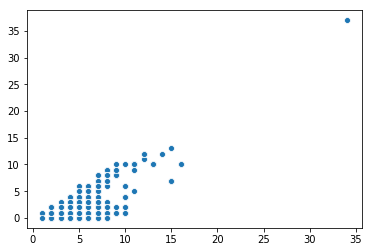

In [9]:
# pocet H-akceptoru vs. pocet H-donoru
seaborn.scatterplot(x=[x[0] for x in data], y=[x[1] for x in data])

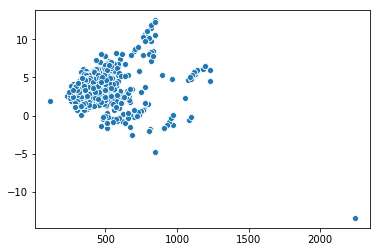

In [10]:
# molekularni hmotnost vs. logP
seaborn.scatterplot(x=[x[2] for x in data], y=[x[3] for x in data])

## 2. PCA mapa

### 2.2 Porovnani agonistu a antagonistu

In [11]:
# normalizace dat:
norm_data = preprocessing.scale(data)

In [12]:
# pocet hlavnich komponent = 6, pak data
pca = decomposition.PCA(n_components=6)
pca.fit(norm_data)

PCA(copy=True, iterated_power='auto', n_components=6, random_state=None,
  svd_solver='auto', tol=0.0, whiten=False)

In [13]:
pca_data = pca.transform(norm_data)

In [14]:
print(pca.components_)

[[ 0.44173152  0.44551279  0.41055106 -0.2136145   0.47025642  0.41360271]
 [ 0.05958473 -0.24629499  0.43295532  0.78521506 -0.13891064  0.33537931]
 [ 0.78224786 -0.34408608  0.11309416 -0.03110866 -0.08271934 -0.4990917 ]
 [ 0.25075056 -0.45394865 -0.35669479 -0.29606883 -0.22783688  0.68136422]
 [-0.35493043 -0.54265853  0.60558845 -0.42879931  0.16394877 -0.0453948 ]
 [-0.02365901 -0.3491622  -0.37045741  0.25556371  0.82093325 -0.03229713]]


In [15]:
print(pca.explained_variance_ratio_)

[0.72085926 0.21208169 0.03801862 0.02156872 0.00502664 0.00244508]


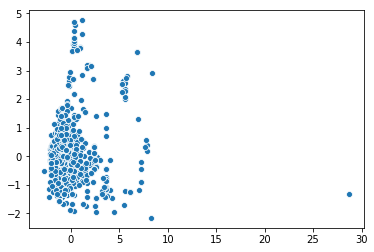

In [16]:
seaborn.scatterplot(x=[x[0] for x in pca_data], y=[x[1] for x in pca_data])

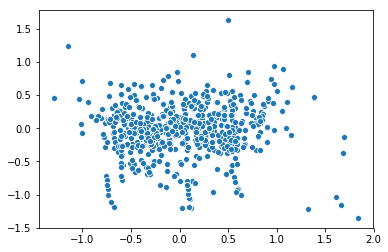

In [17]:
seaborn.scatterplot(x=[x[2] for x in pca_data], y=[x[3] for x in pca_data])

In [18]:
# ulozeni indexu agonistu
ago_index = [i for i,lig in enumerate(ligands['Standard Type']) if lig == 'EC50']
len(ago_index)

586

In [19]:
pca_frame = pd.DataFrame(pca_data, columns=["x","y","z","a","b","c"])

In [20]:
pca_frame["ago"] = [x in ago_index for x in range(len(data))]

In [21]:
pca_frame

,x,y,z,a,b,c,ago
0,3.456744,-0.790634,-0.801127,0.290546,0.106757,0.238742,True
1,1.639316,3.087907,0.910602,0.460024,0.014464,0.143403,False
2,1.869410,3.196642,0.786604,0.158750,-0.159038,0.023290,False
3,-0.671883,-1.304342,0.456749,0.202174,-0.011527,-0.004981,False
4,-0.046762,0.530728,0.565165,0.351501,0.232682,-0.061782,True
5,-0.269374,0.206819,0.260527,-0.123888,0.086073,-0.091757,True
6,-1.475510,-0.434414,-0.212062,-0.245116,-0.276385,0.008244,False
7,-1.235903,0.048863,0.302130,-0.227780,0.055700,0.048238,True
8,-0.812312,-0.291276,0.454381,0.325353,0.069361,-0.061754,True
9,3.698173,-1.337645,-0.522517,0.316999,-0.227555,0.022738,False


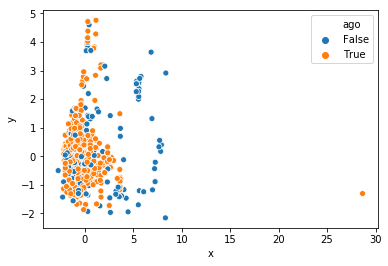

In [22]:
seaborn.scatterplot(x="x", y="y", data=pca_frame, hue="ago")

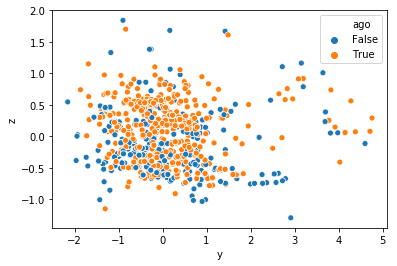

In [39]:
seaborn.scatterplot(x="y", y="z", data=pca_frame, hue="ago")

### 2.2 Zobrazeni agonistu a antagonistu na pozadi DB Zinc

In [23]:
zinc = pd.read_csv('../../data/zinc2015_0_vil_0_sa_to_6_ivan.csv') 
len(zinc)

9806

In [24]:
zinc[:5]

,idx,smi,syba,SAScore,SCScore,Berzt,Withlock,Barone,SMCM,TWC
0,ZINC000033838849,COC1C(OC(=O)C=CC=CC=CC=CC(=O)O)CCC2(CO2)C1C1(C...,-52.392389,5.296526,3.104507,873,45,663,67.079,14
1,ZINC000348308268,CCC1(CC)C(NC(=O)C(=O)N2CC3CCC(C2)O3)C(C)C1OC,4.533230,5.291688,3.397787,493,32,502,47.521,10
2,ZINC000471263265,CCOC(=O)C(CC)N(C(=O)C12CC3CC(C1)CC(C(F)(F)F)(C...,20.849132,5.259294,3.244047,643,33,600,58.200,12
3,NaN,[O-][S+]1C2CCC1CN(Cc1cccc(F)c1O)CC2,27.831656,5.083364,3.743918,470,23,441,36.445,8
4,ZINC000224927665,O=C1C2CC(c3ccccc3)=C3C4C=CC(C5C(=O)N(c6ccc([N+...,-4.815460,5.082399,3.769644,1952,74,1274,96.262,20


In [25]:
mols_zinc = [Chem.MolFromSmiles(mol) for mol in zinc['smi']]
len(mols_zinc)

9806

In [26]:
zinc["Molecule_rdkit"] = mols_zinc

In [27]:
#napocitani deskriptoru pro molekuly ze Zincu
data_zinc = [[f(mol) for f in lip_func] for mol in mols_zinc]

In [28]:
data_zinc.extend(data)
len(data_zinc),len(data)+len(mols_zinc)

(10826, 10826)

In [29]:
norm_data_zinc = preprocessing.scale(data_zinc)
pca_zinc = decomposition.PCA(n_components=6)
pca_zinc.fit(norm_data_zinc)
pca_data_zinc = pca_zinc.transform(norm_data_zinc)

In [38]:
labels_aa = ['ago' if pca_frame["ago"][i]==True else 'antag' for i in range(len(data))]
labels = ['zinc']*len(mols_zinc)
labels.extend(labels_aa)
len(labels)

10826

In [40]:
pca_frame_zinc = pd.DataFrame(pca_data_zinc, columns=["x","y","z","a","b","c"])

In [41]:
pca_frame_zinc["labels"] = labels

In [42]:
pca_frame_zinc[:5]

,x,y,z,a,b,c,labels
0,1.845853,1.481908,-0.684067,-0.906758,-0.028423,0.460337,zinc
1,-0.524302,-1.078012,-0.174091,-0.003961,0.525744,-0.044567,zinc
2,-1.150578,1.621437,-0.064050,-0.275407,0.506940,0.290656,zinc
3,-1.826418,-1.034037,0.212440,0.422333,0.145506,-0.138644,zinc
4,3.025632,1.854347,-2.730372,1.723733,0.673653,1.513131,zinc


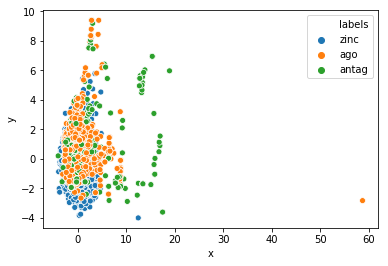

In [43]:
seaborn.scatterplot(x="x", y="y", data=pca_frame_zinc, hue="labels")

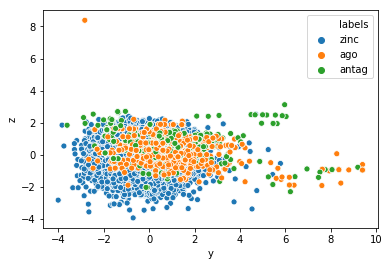

In [44]:
seaborn.scatterplot(x="y", y="z", data=pca_frame_zinc, hue="labels")

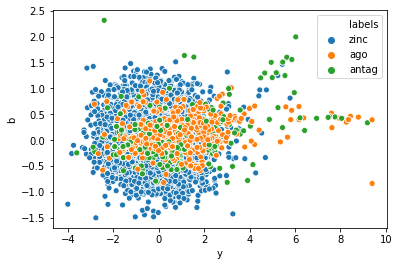

In [48]:
seaborn.scatterplot(x="y", y="b", data=pca_frame_zinc, hue="labels")

## 3. MDS

## 4. Predikce aktivity

In [31]:
#spocitani fingerprintu
ligands["FP"] = [Chem.GetMorganFingerprintAsBitVect(mol,2,nBits=1024) 
              for mol in ligands["Molecule_rdkit"]]

In [32]:
ligands[:5]

,Molecule,Standard Type,Standard Relation,Standard Value,Standard Units,pChEMBL Value,Comment,Compound Key,Assay,Assay Description,...,Published Units,Canonical Smiles,Data Validity Comment,Document Journal,Document Year,SRC ID,UO Units,Potential Duplicate,Molecule_rdkit,FP
0,CHEMBL247758,EC50,=,49.0,nM,7.31,NaN,22,CHEMBL887072,Agonist activity at human cloned mu opioid rec...,...,NaN,CC(C)C[C@H](NC(=O)[C@H](Cc1ccccc1)NC(=O)CNC(=O...,NaN,Bioorg. Med. Chem. Lett.,2007.0,1,UO_0000065,False,<rdkit.Chem.rdchem.Mol object at 0x7f7440957c10>,"[0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
1,CHEMBL2113275,IC50,=,25.0,nM,7.60,NaN,8,CHEMBL919398,Agonist activity at human opioid gamma recepto...,...,NaN,O[C@]12CCC(=O)[C@@H]3Oc4c(OC(=O)CCCCCCCCC(=O)O...,NaN,J. Med. Chem.,2007.0,1,UO_0000065,False,<rdkit.Chem.rdchem.Mol object at 0x7f7440957d00>,"[0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, ..."
2,CHEMBL224671,IC50,=,18.0,nM,7.75,NaN,6,CHEMBL919398,Agonist activity at human opioid gamma recepto...,...,NaN,O[C@@H]1CC[C@@]2(O)[C@H]3Cc4ccc(OC(=O)CCCCCCCC...,NaN,J. Med. Chem.,2007.0,1,UO_0000065,False,<rdkit.Chem.rdchem.Mol object at 0x7f7440957ee0>,"[0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, ..."
3,CHEMBL80,IC50,=,2.0,nM,8.70,NaN,Naloxone,CHEMBL757060,Binding affinity against mu-opiate receptor (h...,...,NaN,Oc1ccc2C[C@H]3N(CC=C)CC[C@@]45[C@@H](Oc1c24)C(...,NaN,J. Med. Chem.,2001.0,1,UO_0000065,False,<rdkit.Chem.rdchem.Mol object at 0x7f7440957d50>,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
4,CHEMBL2113301,EC50,=,11.7,nM,7.93,NaN,5h,CHEMBL896955,Agonist activity at human mu opioid receptor e...,...,NaN,COc1ccccc1\C=C\C(=O)NC[C@H]2C[C@]34CC[C@@]2(OC...,NaN,J. Med. Chem.,2007.0,1,UO_0000065,False,<rdkit.Chem.rdchem.Mol object at 0x7f7440957f80>,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."


In [33]:
train, test = model_selection.train_test_split(ligands)
len(train), len(test)

(765, 255)

In [34]:
#regrese - natrenovani na pCheEMBL hodnote
predictor = RandomForestRegressor()
predictor.fit([fp for fp in train["FP"]], 
              list(train["pChEMBL Value"])) 

/home/eva/miniconda3/envs/pnl/lib/python3.6/site-packages/sklearn/ensemble/forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=None,
           oob_score=False, random_state=None, verbose=0, warm_start=False)

In [35]:
list(zip(predictor.predict(list(test["FP"])), 
         list(test["pChEMBL Value"])))

[(7.148000000000001, 7.54),
 (7.711000000000001, 7.6),
 (8.238600000000002, 7.57),
 (8.748000000000001, 8.92),
 (7.8066666666666675, 8.25),
 (7.706000000000001, 7.71),
 (7.6659999999999995, 7.0),
 (8.250076923076922, 9.89),
 (7.601000000000001, 9.68),
 (7.987522276128272, 8.8),
 (8.714000000000002, 8.05),
 (9.223, 8.84),
 (7.290000000000001, 7.82),
 (7.677666666666665, 7.84),
 (8.670449999999999, 8.55),
 (8.437999999999999, 9.49),
 (8.931000000000001, 8.73),
 (7.925999999999999, 8.62),
 (8.371999999999998, 7.2),
 (8.076477777777779, 7.27),
 (8.213000000000001, 8.77),
 (8.917492673992674, 9.1),
 (8.1585, 8.6),
 (8.516000000000002, 8.6),
 (7.731, 10.2),
 (7.108333333333334, 7.24),
 (8.0385, 8.89),
 (8.477826923076922, 7.28),
 (7.987522276128272, 9.37),
 (7.9879999999999995, 9.36),
 (8.126999999999999, 7.87),
 (7.987522276128272, 7.26),
 (8.345816666666668, 8.0),
 (7.179266666666666, 7.55),
 (8.637333333333334, 8.43),
 (7.3610000000000015, 7.6),
 (7.677666666666665, 8.49),
 (7.98752227612

In [36]:
test["Predict Value"] = predictor.predict(list(test["FP"]))

/home/eva/miniconda3/envs/pnl/lib/python3.6/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.


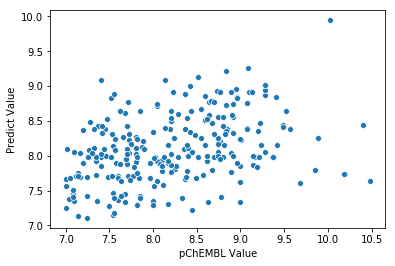

In [37]:
#vykresleni predikovana vs. zmerena hodnota
sns.scatterplot(x = "pChEMBL Value",y = "Predict Value", data=test)